# A Simple Speech Emotion Recognition System

This notebook shows how to create a simple Speech Emotion Recognition (SER) system using [OpenSmile's](https://www.audeering.com/research/opensmile/) ComParE 2006 feature set of statistical functionals. The dataset used was the [EmoDB](http://emodb.bilderbar.info/start.html) dataset of emotional speech, with utterances in german for 7 different emotions (including neutral), spoken by 10 different actors and 10 different sentences. The SER system uses a simple K Nearest Neighbours classifier from the [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) toolkit.

This notebook is for demonstration purposes only, and only provides you with a very simple SER system. In truth, a linear SVC would provide better results than the KNN, however the results are more interesting using the KNN.

As part of this code you will also find:<br>
-preprocess_emodb.py: Here you will find the code used for preprocessing the EmoDB dataset.



To make sure this code runs correctly, download the [EmoDB dataset](http://emodb.bilderbar.info/start.html), extract the .zip file, store it in the main folder of this project, and rename it "EmoDB".

In [1]:
# main imports. you may have to install some of the libraries, for example using pip. Check the respective
# website for more information on how to install them correctly.

import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import opensmile

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## EmoDB data
Let's have a short look at the EmoDB data. The *EmoDB_data* class provides us with some simple methods to explore our dataset.

In [2]:
# import this class to easily handle the EmoDB data
from preprocess_emodb import EmoDB_data
emodb = EmoDB_data()

The sentences spoken out by the EmoDB actors are quite funny. Here you can see the original (german) and the english version of each. 

In [3]:
emodb.get_sentences_info()

,german,english
a01,Der Lappen liegt auf dem Eisschrank.,The tablecloth is lying on the frigde.
a02,Das will sie am Mittwoch abgeben.,She will hand it in on Wednesday.
a04,Heute abend könnte ich es ihm sagen.,Tonight I could tell him.
a05,Das schwarze Stück Papier befindet sich da obe...,The black sheet of paper is located up there b...
a07,In sieben Stunden wird es soweit sein.,In seven hours it will be.
b01,"Was sind denn das für Tüten, die da unter dem ...",What about the bags standing there under the t...
b02,Sie haben es gerade hochgetragen und jetzt geh...,They just carried it upstairs and now they are...
b03,An den Wochenenden bin ich jetzt immer nach Ha...,Currently at the weekends I always went home a...
b09,Ich will das eben wegbringen und dann mit Karl...,I will just discard this and then go for a dri...
b10,"Die wird auf dem Platz sein, wo wir sie immer ...",It will be in the place where we always store it.


As you can see in the dataframe below, we have ten actors that read out the sentences with different emotions. It is possible to easily notice that there are 5 male and 5 female voices, with ages between 21 and 35. One thing that is important is that when we test the performance of our dataset, the testset is completely independent of the training set. This means, not only the samples that we use should not be the same. We should also try to test with speakers that were not in the training dataset. Otherwise out test results may be too optimistic, but not account for new voices it has never heard before.

In [4]:
emodb.get_speaker_info()

,gender,age
03,male,31
08,female,34
09,female,21
10,male,32
11,male,26
12,male,30
13,female,32
14,female,35
15,male,25
16,female,31


Next, we should also have an idea which emotions we are trying to predict, i.e. which labels we are using. In the following example we will use 7 different emotions, as provided by EmoDB. However, we could also choose to use valence labels, which are binary.

In [5]:
emodb.get_emotions_info()

,emotion,valence
W,anger,negative
L,boredom,negative
E,disgust,negative
A,fear,negative
F,happiness,positive
T,sadness,negative
N,neutral,positive


Before we start training, let's have another look at the dataset that we are using. There are 535 samples, and opensmile provices us with 6373 unique features. What each feature represents you can see in the table below as well. They comprise of statistical functionals of different Low Level Descriptors that describe different audio features at short intervals of time for each audio file.
The training data will be composed of the features (X) and the labels (y). Below you can also check the 7 different labels that will be used and how often they occur in the dataset

In [6]:
# We could alternatively use the valence labels, however this would make the system less interesting and we
# would need to account for the imbalance in the dataset, as most emotions in the dataset are negative.
# X, y = emodb.get_full_training_data(labeling="valence")
X, y = emodb.get_full_training_data(labeling="emotion")

In [7]:
X.shape

(535, 6373)

In [8]:

columns = list(emodb._get_audio_info().columns)
columns[3:10] + columns[-7:]

['audspec_lengthL1norm_sma_range',
 'audspec_lengthL1norm_sma_maxPos',
 'audspec_lengthL1norm_sma_minPos',
 'audspec_lengthL1norm_sma_quartile1',
 'audspec_lengthL1norm_sma_quartile2',
 'audspec_lengthL1norm_sma_quartile3',
 'audspec_lengthL1norm_sma_iqr1-2',
 'mfcc_sma_de[14]_peakMeanMeanDist',
 'mfcc_sma_de[14]_peakMeanRel',
 'mfcc_sma_de[14]_minRangeRel',
 'mfcc_sma_de[14]_meanRisingSlope',
 'mfcc_sma_de[14]_stddevRisingSlope',
 'mfcc_sma_de[14]_meanFallingSlope',
 'mfcc_sma_de[14]_stddevFallingSlope']

In [9]:
pd.DataFrame(y, columns=["Emotion"]).value_counts()

Emotion  
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
dtype: int64

## Optimization and Training
Now that we already know more or less what data we are working with, let's start the training process. 
To keep this simple, this notebook will only cover a very simple model class: a KNN classifier, which selects for k nearest neighbours and selects the majority class of these neighbours. 

This section is divided into three parts: 
1) First, we will go through several training runs in order to optimize for the n_neighbours hyperparameter to select the number of neighborus, using Group-K-fold validation to make sure each actor is either in the training or test set on each fold.

2) We will evaluate the results on the training and test sets to determine the best performing hyperparameter.

3) Train the final SER system and store it.


In general, for the optimization of the hyperparameters, the training set is split into a training and validation set. However, because the dataset is quite small, the validation set would probably yield suboptimal hyperparameters.

#### Optimizing the hyperparameter

In [10]:
# This function calculates some of the main metrics that will be used to evaluate the results.
def get_score(true_labels, predictions, labels):
    scores = pd.Series(dtype=float)
    scores["UAR"] = recall_score(true_labels, predictions, average='macro')
    scores["WAR"] = recall_score(true_labels, predictions, average='weighted')
    
    recall_scores = recall_score(true_labels, predictions, average=None, labels=labels)
    for label, rec_score in zip(labels, recall_scores):
        scores[f"recall_{label}"] =  rec_score
        
    scores["recall_mean"] = recall_scores.mean()  
    
    precision_scores = precision_score(true_labels, predictions, average=None, zero_division=0, labels=labels)
    for label, prec_score in zip(labels, precision_scores):
        scores[f"precision_{label}"] =  prec_score
    scores["precision_mean"] = precision_scores.mean() 
    
    f1_scores = f1_score(true_labels, predictions, average=None, labels=labels)
    for label, f1 in zip(labels, f1_scores):
        scores[f"f1_{label}"] =  f1
    scores["f1_mean"] = f1_scores.mean()  

    cm = confusion_matrix(true_labels, predictions, labels=labels)
    
    return scores, cm


In [11]:
# Some hyperparameters for our search and optimization. 
k_folds = 5      #number of folds
hyperparameter_space = range(1, 15)

In [12]:
# Here we will store the results
results_test = pd.DataFrame()
results_train = pd.DataFrame()
confusion_matrices = {}
labels = emodb.emotions["emotion"].to_list()

for n_neighbors in hyperparameter_space:
    confusion_matrices[n_neighbors] = {}

# the EmoDB_data class already provides a generator that allows to go though a desired number of Group-K-Folds,
# providing a dictionary with the training and test X and y data.
for k, train_test_split in tqdm(enumerate(emodb.get_train_test_folds(k_folds=k_folds, labeling="emotion"))):
    X_train = train_test_split["X_train"]
    X_test = train_test_split["X_test"]
    y_train = train_test_split["y_train"]
    y_test = train_test_split["y_test"]
    
    
    # Normalize the values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Let us try 4 different C values and see which is the best
    for n_neighbors in hyperparameter_space:
        
        
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(X_train, y_train)
        
        # calculate the performance on the test set and store values
        test_predictions = clf.predict(X_test)
        scores, confusion_matrices[n_neighbors][k] = get_score(y_test, test_predictions, clf.classes_)
        scores["n_neighbors"] = n_neighbors
        scores["k_fold"] = k
        
        #make sure confusion matrix is ordered correctly:
        permutation = [list(clf.classes_).index(element) for element in labels]
        confusion_matrices[n_neighbors][k][permutation][:, permutation]
        
        results_test = pd.concat([results_test, scores], axis=1)
        
        # calculate the performance on the train set and store values
        train_predictions = clf.predict(X_train)
        scores, _ = get_score(y_train, train_predictions, clf.classes_)
        scores["n_neighbors"] = n_neighbors
        scores["k_fold"] = k
        
        results_train = pd.concat([results_train, scores], axis=1)
        
        
        
results_test = results_test.T
results_train = results_train.T


5it [00:14,  2.94s/it]


#### Evaluation

Now that the classifier has tried different values for the hyperparameter for k=5 folds of training and test sets, we can evaluate the results. 

The first graph shows the Weighted Average Recall over the different values of the hyperparameter that we tested for both the training and the test set. This is a perfect example of how a classifier might overfit to the training set if the n_neighbours are too low, and also speaks to the importance of making the training and testing sets independent in order to measure as close as possible the empirical risk.

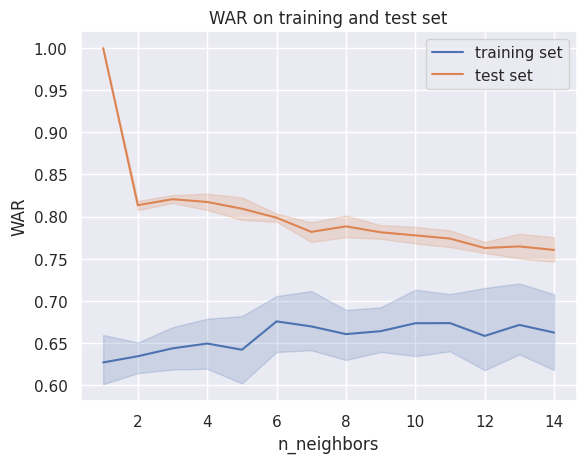

In [13]:
plot = sns.lineplot(data=results_test, x="n_neighbors", y="WAR", label="training set")
plot = sns.lineplot(data=results_train, x="n_neighbors", y="WAR", label="test set")
plot.set_title("WAR on training and test set")
plt.show()

Weighted Average Recall is, in general, a very interesting metric for this kind of study, since it gives us a better understanding about how often the classifier is right. However, if we look at the recall score for the different emotions in the table below, we notice that the classifier has a 91% recall on Anger, however only 23% recall on Happiness. And while the recall is high, we can observe that the classifier is quite biased towards the most common emotions in our dataset, since the precision for Anger is actually quite lower than expected. The F1 score gives a more precise estimate of how well our classifier is doing with certain emotions (and on average), and it seems its actually better at detecting Sadness than Anger, however hapiness is still quite bad. Let's investigate further.

In [14]:
mean_results = results_test.drop("k_fold", axis=1).groupby("n_neighbors").mean().reset_index()
top_index = mean_results["WAR"].argmax()
top_neighbors = int(mean_results.loc[top_index, "n_neighbors"])
mean_results.loc[top_index]

n_neighbors            6.000000
UAR                    0.618896
WAR                    0.675440
recall_anger           0.912513
recall_boredom         0.830410
recall_disgust         0.440949
recall_fear            0.360641
recall_happiness       0.236508
recall_neutral         0.753319
recall_sadness         0.797931
recall_mean            0.618896
precision_anger        0.699153
precision_boredom      0.643271
precision_disgust      0.583636
precision_fear         0.694286
precision_happiness    0.473333
precision_neutral      0.627336
precision_sadness      0.894505
precision_mean         0.659360
f1_anger               0.784779
f1_boredom             0.720458
f1_disgust             0.501364
f1_fear                0.467244
f1_happiness           0.306970
f1_neutral             0.680778
f1_sadness             0.837839
f1_mean                0.614205
Name: 5, dtype: float64

Below we can see a Confusion Matrix. It shows the amount of samples in the test set that have a particular true value, and how our classifier predicted them. Similar to the confusion matrix in binary classification that gives us the True Positives, True Negatives and the False positives or negatives, with multiclass classification, we see which labels were confounded with which. 
In general, it is interesting to look at the values outside the diagonal of correctly classifier samples to understand how the classifier is wrong, and what would be the cause.
In our particular case, we see that Anger was quite often correct, however sometimes mistaken for either happiness, or even fear, sadness or disgust. The other way round, Happiness was more often classifier as Anger than Happiness itself. Of course, one can try to imagine that maybe emotions are hard to distinguish, both for humans and for computers, however, the inbalance in the dataset can also be a major cause (remember that Anger was the most common label, while Happiness the least common).


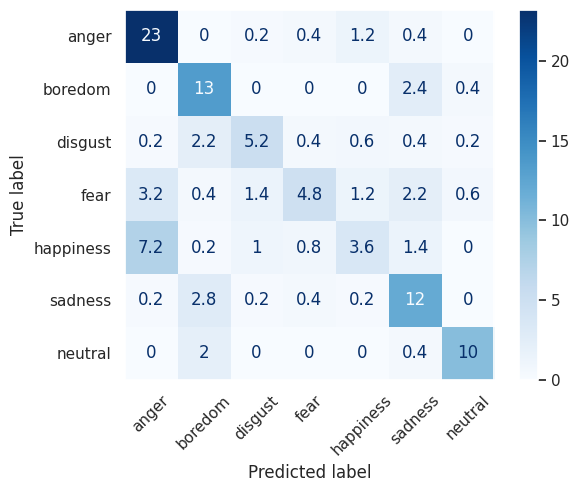

In [15]:
# get confusion matrix for top neighbor hyperparameter, averaged over the kfolds
top_cm = np.array(list(confusion_matrices[top_neighbors].values())).mean(axis=0)
    

disp = ConfusionMatrixDisplay(confusion_matrix=top_cm, display_labels=labels).plot(cmap="Blues")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

#### Final training
Now that we have tested our best performing hyperparameter for the number of neighbours for the KNN classifier, and have some understanding of how it would perform on unseen data, it is time to train the final classifier on the whole dataset that we have available. Hopefully it works a bit better, however there is no way to measure it unless we gather more data.

In [16]:
X, y = emodb.get_full_training_data(labeling="emotion")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

clf = KNeighborsClassifier(n_neighbors=top_neighbors)
clf.fit(X_train, y_train)

pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(clf, open('classifier.pkl', 'wb'))

## Make it ready to use!
Now, lets have a Simple Speech Emotion Recognizer class that is ready to be used. Once instantiated, one can just ask it to *predict* a .wav file with a voice recording and get the (hopefully) correct emotion.

In [17]:
class SimpleSpeechEmotionRecognizer():

    def __init__(self, warnings=True):
        self.smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
        
        self.scaler = pickle.load(open("scaler.pkl", 'rb'))
        self.classifier = pickle.load(open("classifier.pkl", 'rb'))
        
    def _get_opensmile_from_wav(self, file_path: str):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"'{file_path}' was not found")

        data = self.smile.process_file(file_path)

        data = pd.DataFrame(data).reset_index()
        return data
    
    def predict(self, file_path: str)->str:
        data = self._get_opensmile_from_wav(file_path=file_path)
        
        X = data.drop(["file", "start", "end"], axis=1).copy().to_numpy()
        X = self.scaler.transform(X)
        prediction = self.classifier.predict(X)[0]

        return prediction


#### Let's test it out

In [18]:
simple_SER = SimpleSpeechEmotionRecognizer()

In [19]:
# in the file name 03a01Wa.wav, the "W" letter stands for "Wut", meaning Anger in german
simple_SER.predict("EmoDB/wav/03a01Wa.wav")

'anger'